# Optimize 4% coverage device

optimize both for the effective overlap efficiency factor of 0.13 and 0.45. Ideally, the design parameters should not vary significantly between the two

In [1]:
import numpy as np
import darkopt as dark # can import either entire package
from darkopt import materials, optimize # or import submodules seperately 
import darkopt.plotting as plot
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from scipy.signal import savgol_filter
import time

from matplotlib import rcParams
import matplotlib.cm as cm



nice_fonts = {
        # Use LaTeX to write all text
        #"text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 14,
        "font.size": 12,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
}

rcParams.update(nice_fonts)
#rcParams['axes.grid'] = True
rcParams['grid.linestyle'] = '--'
rcParams['xtick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.direction'] = 'in'
rcParams['ytick.right'] = True

### Optimzie for Rn

In [16]:
desired_coverage = 0.04

n_norm_points = 40

det_thickness = 4e-3
l_tes0 = 100e-6
l_tes_bnds = [5e-6, 300e-6]
l_overlap0 = 10e-6
l_overlap_bnds = [5e-06, 18e-6]
l_fin0 = 100e-6
l_fin_bnds = [25e-6, 500e-6]
n_fin0 = 4
n_fin_bnds = [2,6]
w_overlap0 = 15e-6
w_overlap_bnds = [5e-6, 40e-6]

res_n = np.linspace(250e-3, 550e-3, n_norm_points)
rp = 2e-3
ahole = 4.9e-11
safety = 200e-6

w_overlap0 = 'circle'
w_overlap_bnds = [5e-6, 40e-6]
bounds=[l_tes_bnds,l_overlap_bnds ,l_fin_bnds]# , n_fin_bnds]
fix_w_overlap=True

veff_WAloverlap=.45 # measured

res = np.zeros((5,n_norm_points))
length = np.zeros((5, n_norm_points))
overlap = np.zeros((5, n_norm_points))
fin = np.zeros((5, n_norm_points))
surf = np.zeros((5, n_norm_points))
ntes = np.zeros((5, n_norm_points))
success = np.zeros((5, n_norm_points))
cost = np.zeros((5, n_norm_points))


for jj in range(2,7):
    for ii in tqdm(range(len(res_n))):
        det1, eres, params, result = optimize.optimize_detector( tes_length0=l_tes0,
                                                            tes_l_overlap0=l_overlap0,
                                                            l_fin0=l_fin0,
                                                            n_fin0=jj,
                                                            per_Al = desired_coverage,   
                                                            fix_w_overlap=fix_w_overlap,
                                                            w_overlap = w_overlap0,
                                                            #tes_width=w,
                                                            abs_type="Si", 
                                                            abs_shape="square", 
                                                            abs_height=det_thickness, 
                                                            abs_width=1e-2, 
                                                            w_safety=safety,
                                                            sigma=220000000.0,
                                                            rn=res_n[ii],
                                                            rp=rp,
                                                            L_tot=5e-08,
                                                            ahole=ahole, 
                                                            con_type='ellipse',
                                                            veff_WAloverlap=veff_WAloverlap,
                                                             bounds = bounds, 
                                                            w_overlap_bounds=w_overlap_bnds, 
                                                              verbose=False)
        res[jj-2,ii]=det1.calc_res()
        length[jj-2,ii]=det1.QET.TES.l
        overlap[jj-2,ii]=det1.QET.TES.l_overlap
        fin[jj-2,ii]=det1.QET.l_fin
        surf[jj-2,ii]=det1._fSA_qpabsorb
        ntes[jj-2,ii]=det1.QET.TES.nTES
        cost[jj-2,ii]=result.fun
        success[jj-2,ii]=result.success
    
    

    

In [38]:
np.save('res_4.np', res)
np.save('length_4.np', length)
np.save('overlap_4.np', overlap)
np.save('fin_4.np', fin)
np.save('surf_4.np', surf)
np.save('cost_4.np',cost)
np.save('success_4.np', success)

np.save('ntes_4.np', ntes)
#np.save('nfin_4.np', nf)

In [18]:
((res_n > .3) & (res_n < .535)).sum()

32

(300.0, 535.0)

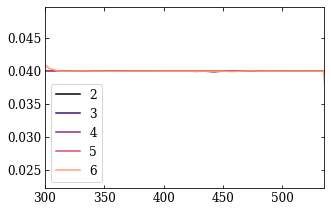

In [30]:
colors = cm.magma(np.linspace(0,1,res.shape[0]+1))
plt.figure(figsize=(5, 5*2/3))
for ii in range(res.shape[0]):
    plt.plot(res_n*1e3, surf[ii], color=colors[ii], label=f'{ii+2}')
plt.legend()
plt.xlim(300,535)

ValueError: x and y must have same first dimension, but have shapes (4,) and (40,)

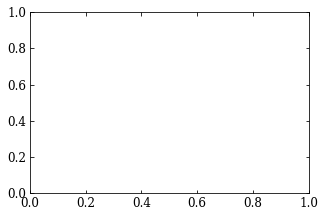

In [61]:
colors = cm.magma(np.linspace(0,1,res.shape[0]+1))
plt.figure(figsize=(5, 5*2/3))
for ii in range(res.shape[0]):
    plt.step(res_n[c]*1e3, success[ii], color=colors[ii], label=f'{ii+2}')
    #plt.plot(res_n*1e3, savgol_filter(res[ii], 21, 1)*1e3, color=colors[ii], label=f'{ii+2}')
plt.ylabel('Success')
plt.xlabel(r'$R_N\, [\mathrm{m}\Omega]$')
plt.legend()

<>:9: DeprecationWarning: invalid escape sequence \s
<>:9: DeprecationWarning: invalid escape sequence \s
<ipython-input-41-1e95e724602c>:9: DeprecationWarning: invalid escape sequence \s
  plt.ylabel('$\sigma_E$ [eV]')


(250.0, 500.0)

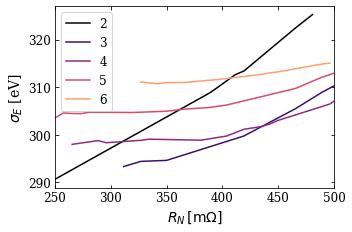

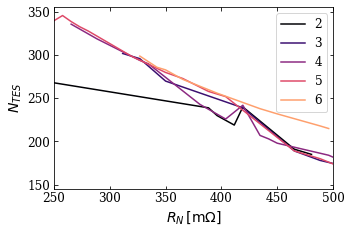

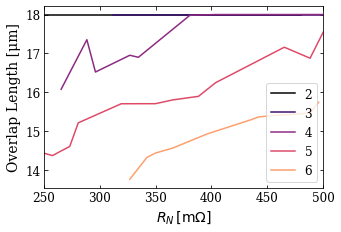

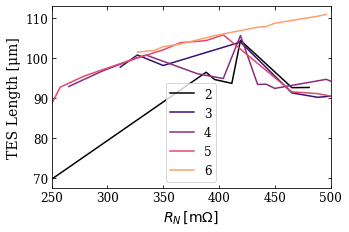

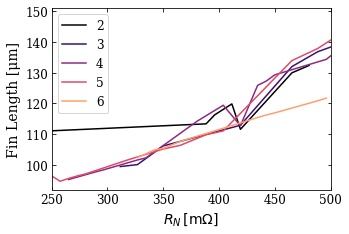

In [41]:
colors = cm.magma(np.linspace(0,1,res.shape[0]+1))
plt.figure(figsize=(5, 5*2/3))
for ii in range(res.shape[0]):
    c = success[ii] == True
    #c = c1 & (res_n > .3) & (res_n < .535)
    #c = np.ones_like(overlap[ii], dtype=bool)
    plt.plot(res_n[c]*1e3, res[ii][c]*1e3, color=colors[ii], label=f'{ii+2}')
    #plt.plot(res_n*1e3, savgol_filter(res[ii], 21, 1)*1e3, color=colors[ii], label=f'{ii+2}')
plt.ylabel('$\sigma_E$ [eV]')
plt.xlabel(r'$R_N\, [\mathrm{m}\Omega]$')
plt.legend()
plt.xlim(250,500)


plt.figure(figsize=(5, 5*2/3))
for ii in range(res.shape[0]):
    c = overlap[ii] < 16e-6
    c = np.ones_like(overlap[ii], dtype=bool)
    c = success[ii] == True
    plt.plot(res_n[c]*1e3, ntes[ii][c], color=colors[ii], label=f'{ii+2}')
plt.ylabel('$N_{TES}$')
plt.xlabel(r'$R_N\, [\mathrm{m}\Omega]$')
plt.legend()
plt.xlim(250,500)


plt.figure(figsize=(5, 5*2/3))
for ii in range(res.shape[0]):
    c = overlap[ii] < 16e-6
    c = np.ones_like(overlap[ii], dtype=bool)
    c = success[ii] == True
    plt.plot(res_n[c]*1e3, overlap[ii][c]*1e6, color=colors[ii], label=f'{ii+2}')
plt.ylabel('Overlap Length [μm]')
plt.xlabel(r'$R_N\, [\mathrm{m}\Omega]$')
plt.legend()
plt.xlim(250,500)


plt.figure(figsize=(5, 5*2/3))
for ii in range(res.shape[0]):
    c = overlap[ii] < 16e-6
    c = np.ones_like(overlap[ii], dtype=bool)
    c = success[ii] == True
    plt.plot(res_n[c]*1e3, length[ii][c]*1e6, color=colors[ii], label=f'{ii+2}')
plt.ylabel('TES Length [μm]')
plt.xlabel(r'$R_N\, [\mathrm{m}\Omega]$')
plt.legend()
plt.xlim(250,500)

plt.figure(figsize=(5, 5*2/3))
for ii in range(res.shape[0]):
    c = overlap[ii] < 16e-6
    c = np.ones_like(overlap[ii], dtype=bool)
    c = success[ii] == True
    plt.plot(res_n[c]*1e3, fin[ii][c]*1e6, color=colors[ii], label=f'{ii+2}')
plt.ylabel('Fin Length [μm]')
plt.xlabel(r'$R_N\, [\mathrm{m}\Omega]$')
plt.legend()
plt.xlim(250,500)

## Find optimum 5 fin at Rn=325

In [60]:
desired_coverage = 0.04
det_thickness = 4e-3

l_tes0 = 100e-6
l_tes_bnds = [5e-6, 300e-6]
l_overlap0 = 10e-6
l_overlap_bnds = [5e-06, 40e-6]
l_fin0 = 100e-6
l_fin_bnds = [25e-6, 500e-6]
n_fin0 = 5
n_fin_bnds = [2,6]
w_overlap0 = 15e-6
w_overlap_bnds = [5e-6, 40e-6]

res_n = 325e-3
rp = 2e-3
ahole = 4.9e-11
safety = 200e-6

w_overlap0 = 'circle'
w_overlap_bnds = [5e-6, 40e-6]
bounds=[l_tes_bnds,l_overlap_bnds ,l_fin_bnds ]
fix_w_overlap=True

det_opt_13_list = []
det_opt_45_list = []

suc1 = np.ones(20, dtype=bool)
suc2 = np.ones(20, dtype=bool)

res_n = np.linspace(310e-3, 340e-3, 20)
for ii in tqdm(range(len(res_n))):
    
    veff_WAloverlap=.13 # theoretical
    det_opt_13, eres, params, result = optimize.optimize_detector( tes_length0=l_tes0,
                                                        tes_l_overlap0=l_overlap0,
                                                        l_fin0=l_fin0,
                                                        n_fin0=n_fin0,
                                                        per_Al = desired_coverage,   
                                                        fix_w_overlap=fix_w_overlap,
                                                        w_overlap = w_overlap0,
                                                        #tes_width=w,
                                                        abs_type="Si", 
                                                        abs_shape="square", 
                                                        abs_height=det_thickness, 
                                                        abs_width=1e-2, 
                                                        w_safety=safety,
                                                        sigma=220000000.0,
                                                        rn=res_n[ii],
                                                        rp=rp,
                                                        L_tot=5e-08,
                                                        ahole=ahole, 
                                                        con_type='ellipse',
                                                        veff_WAloverlap=veff_WAloverlap,
                                                         bounds = bounds, 
                                                        w_overlap_bounds=w_overlap_bnds
                                                         , verbose=False)
    suc1[ii] = result.success

    veff_WAloverlap=.45 # measured
    
    det_opt_45, eres, params, result = optimize.optimize_detector( tes_length0=l_tes0,
                                                        tes_l_overlap0=l_overlap0,
                                                        l_fin0=l_fin0,
                                                        n_fin0=n_fin0,
                                                        per_Al = desired_coverage,   
                                                        fix_w_overlap=fix_w_overlap,
                                                          w_overlap = w_overlap0,
                                                        #tes_width=w,
                                                        abs_type="Si", 
                                                        abs_shape="square", 
                                                        abs_height=det_thickness, 
                                                        abs_width=1e-2, 
                                                        w_safety=safety,
                                                        sigma=220000000.0,
                                                        rn=res_n[ii],
                                                        rp=rp,
                                                        L_tot=5e-08,
                                                        ahole=ahole, 
                                                        con_type='ellipse',
                                                        veff_WAloverlap=veff_WAloverlap,
                                                        bounds = bounds, 
                                                        w_overlap_bounds=w_overlap_bnds
                                                          , verbose=False)
    suc2[ii] = result.success
    det_opt_13_list.append(det_opt_13)
    det_opt_45_list.append(det_opt_45)


We can see that the TES length and Fin length are largely unchanged between the two designs, only the overlap region changes, which makes sense

In [62]:
c = suc1 & suc2
c.sum()

1

In [85]:
absorber = det_opt_13._absorber
qet = det_opt_13.QET
tes = det_opt_13.QET.TES
det = det_opt_13
rn = 325e-3

tc = 70e-3
#tc = 40e-3
material=dark.TESMaterial(Tc=tc)

n_fin = tes.n_fin
l = (np.mean(np.array([d.QET.TES.l for d in det_opt_13_list])[suc1]) \
     + np.mean(np.array([d.QET.TES.l for d in det_opt_45_list])[suc2]))/2
w = (np.mean(np.array([d.QET.TES.w for d in det_opt_13_list])[suc1]) \
     + np.mean(np.array([d.QET.TES.w for d in det_opt_45_list])[suc2]))/2
l_overlap = np.mean(np.array([d.QET.TES.l_overlap for d in det_opt_13_list])[suc1])*1/3 \
     + np.mean(np.array([d.QET.TES.l_overlap for d in det_opt_45_list])[suc2])*2/3
w_overlap = 'circle'
l_fin = (np.mean(np.array([d.QET.l_fin for d in det_opt_13_list])[suc1]) \
     + np.mean(np.array([d.QET.l_fin for d in det_opt_45_list])[suc2]))/2
veff_WAloverlap=.45

abso1 = dark.Absorber(name=absorber._name, shape=absorber._shape,
                height=absorber._h, width=absorber._width,
                w_safety=absorber._w_safety)

tes1 = dark.TES(length=l, width=tes.w, l_overlap=l_overlap, n_fin=n_fin, sigma=tes.sigma,
           rn=rn, rsh=tes.rsh, rp=tes.rp, L_tot=tes.L, tload=tes.tload, 
           w_overlap=w_overlap, w_fin_con=tes.w_fin_con, h=tes.h, 
           veff_WAloverlap=veff_WAloverlap, veff_WFinCon=tes.veff_WFinCon, 
           con_type=tes.con_type, material=material, operating_point=tes.fOp,
           alpha=tes.alpha, beta=tes.beta, wempty_fin=tes.wempty_fin, 
           wempty_tes=tes.wempty_tes, n=tes.n, Qp=tes.Qp, t_mc=tes.t_mc,
           w_overlap_stem=tes.w_overlap_stem,  l_c=tes.l_c, 
           l_overlap_pre_ellipse=tes.l_overlap_pre_ellipse)

qet1 = dark.QET(l_fin=l_fin, h_fin=qet.h_fin, TES=tes1, ahole=qet.ahole, ePQP=qet.ePQP,
           eff_absb=qet.eff_absb, nhole_per_fin=qet.nhole_per_fin, 
           type_qp_eff=qet.type_qp_eff)

det1 = dark.Detector(abso1, qet1, n_channel=det._n_channel, w_rail_main=det.w_rail_main, 
                w_railQET=det.w_railQET, bonding_pad_area=det.bonding_pad_area,
                freqs=det.freqs )

print(f"resolution: {det1.calc_res()*1e3:.1f} [meV]")
print(f"TES Length = {det1.QET.TES.l*1e6:.1f} [μm]")
print(f"Overlap Legth = {det1.QET.TES.l_overlap*1e6:.1f} [μm]")
print(f"Overlap Width = {det1.QET.TES.w_overlap*1e6:.1f} [μm]")
print(f"Fin Length = {det1.QET.l_fin*1e6:.1f} [μm]")
print(f"Fin Height = {det1.QET.h_fin*1e6:.1f} [μm]")
print(f"N Fins = {det1.QET.TES.n_fin}")
print(f'Total Al surface coverage = {det1._fSA_qpabsorb*100:.3f} [%]')
print(f'percent active Al = {det1.fSA_active*100:.3f} [%]')
print(f'percent passive Al = {det1.fSA_passive*100:.3f} [%]')
print(f'TES thermal fall time τ0  = {det1.QET.TES.tau0*1e6:.2f} [μs]')
print(f'TES response time τ-  = {det1.QET.TES.taup_m*1e6:.2f} [μs]')
print(f'Phonon collection time constant = {det1._t_pabsb*1e6:.2f} [μs]')
print(f'Absolute phonon collection energy efficiency = {det1._eEabsb*100:.2f} [%]')
print(f'Number of TESs = {det1.QET.TES.nTES}')
print(f'Rn = {det1.QET.TES.rn*1e3:.1f} [mOhms]')
print(f'Close Packed: {det1._close_packed}')
    

resolution: 1125.1 [meV]
TES Length = 99.7 [μm]
Overlap Legth = 15.8 [μm]
Overlap Width = 31.6 [μm]
Fin Length = 102.5 [μm]
Fin Height = 0.6 [μm]
N Fins = 5
Total Al surface coverage = 4.006 [%]
percent active Al = 3.592 [%]
percent passive Al = 0.414 [%]
TES thermal fall time τ0  = 696.21 [μs]
TES response time τ-  = 9.71 [μs]
Phonon collection time constant = 24.37 [μs]
Absolute phonon collection energy efficiency = 22.86 [%]
Number of TESs = 295
Rn = 325.0 [mOhms]
Close Packed: False


In [86]:
97*2/5

38.8

### Plots

(<Figure size 486x320.76 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fef731f5160>)

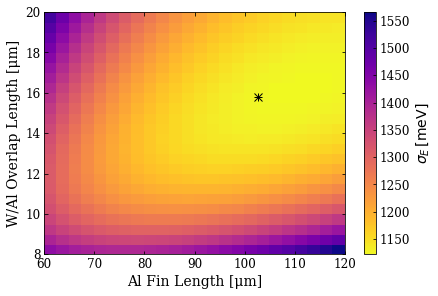

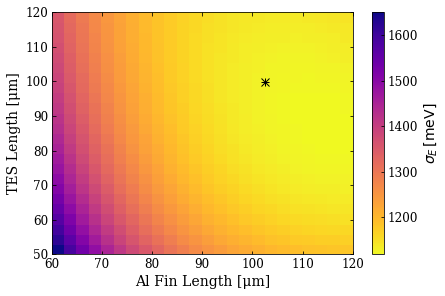

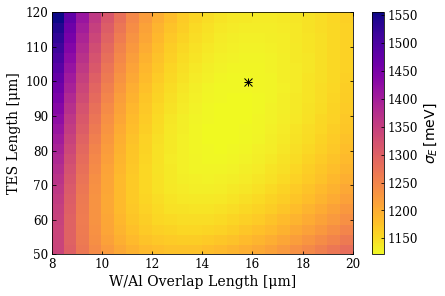

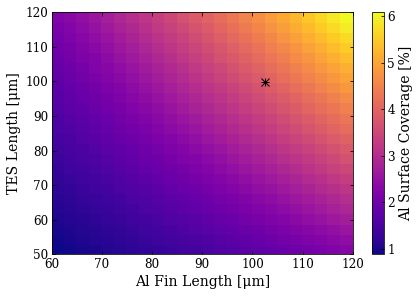

In [87]:
n = 25

l = np.linspace(50e-6, 120e-6, n)
l_f = np.linspace(60e-6, 120e-6, n)
l_overlap = np.linspace(8e-6, 20e-6, n)

plot.plot_loverlap_vs_lfin(l_overlap, l_f, det1, val='energy')
plot.plot_ltes_vs_lfin(l, l_f, det1, val='energy')
plot.plot_ltes_vs_loverlap(l, l_overlap, det1, val='energy')


plot.plot_ltes_vs_lfin(l, l_f, det1, val='al')


(<Figure size 486x320.76 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fef6f64c9d0>)

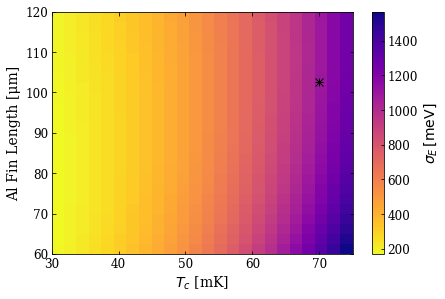

In [94]:
plot.plot_lfin_vs_tc(l_f, np.linspace(30e-3,75e-3,25), det1, val='energy')

### 2 channel device

In [3]:
desired_coverage = 0.04

l_tes0 = 100e-6
l_tes_bnds = [5e-6, 300e-6]
l_overlap0 = 10e-6
l_overlap_bnds = [5e-06, 40e-6]
l_fin0 = 100e-6
l_fin_bnds = [25e-6, 500e-6]
n_fin0 = 4
n_fin_bnds = [2,6]

res_n = 350e-3
rp = 2e-3
ahole = 4.9e-11


bounds=[l_tes_bnds,l_overlap_bnds ,l_fin_bnds , n_fin_bnds]
fixrn=True

veff_WAloverlap=.13 # theoretical
print(f'Effective W/Al volume = {veff_WAloverlap}')
det_opt_1, eres, params = optimize.optimize_detector( tes_length0=l_tes0,
                                                    tes_l_overlap0=l_overlap0,
                                                    l_fin0=l_fin0,
                                                    n_fin0=n_fin0,
                                                    per_Al = desired_coverage,   
                                                    fixrn=fixrn,
                                                    #tes_width=w,
                                                    abs_type="Si", 
                                                    abs_shape="square", 
                                                    abs_height=1e-3, 
                                                    abs_width=1e-2, 
                                                    w_safety=3e-3,
                                                    sigma=220000000.0,
                                                    rn=res_n,
                                                    rp=rp,
                                                    L_tot=5e-08,
                                                    ahole=ahole, 
                                                    con_type='ellipse',
                                                    veff_WAloverlap=veff_WAloverlap,
                                                     n_channel=2,
                                                    bounds = bounds)
veff_WAloverlap=.45 # measured
print(f'Effective W/Al volume = {veff_WAloverlap}')
det_opt_1, eres, params = optimize.optimize_detector( tes_length0=l_tes0,
                                                    tes_l_overlap0=l_overlap0,
                                                    l_fin0=l_fin0,
                                                    n_fin0=n_fin0,
                                                    per_Al = desired_coverage,   
                                                    fixrn=fixrn,
                                                    #tes_width=w,
                                                    abs_type="Si", 
                                                    abs_shape="square", 
                                                    abs_height=1e-3, 
                                                    abs_width=1e-2, 
                                                    w_safety=3e-3,
                                                    sigma=220000000.0,
                                                    rn=res_n,
                                                    rp=rp,
                                                    L_tot=5e-08,
                                                    ahole=ahole, 
                                                    con_type='ellipse',
                                                    veff_WAloverlap=veff_WAloverlap,
                                                     n_channel=2,
                                                    bounds = bounds)


Effective W/Al volume = 0.13
resolution: 108.1 [meV]
TES Length = 69.6 [μm]
Overlap Legth = 18.5 [μm]
Fin Length = 77.5 [μm]
Fin Height = 0.6 [μm]
N Fins = 4
Total Al surface coverage = 4.000 [%]
Absolute phonon collection energy efficiency = 31.54 [%]
Number of TESs = 191
Rn = 350.0 [mOhms]
Close Packed: True
Phase margin = 387.4 [%] (phase_sep_length  - tes_length )/tes_length )
---------------------------------


Effective W/Al volume = 0.45
resolution: 154.5 [meV]
TES Length = 70.7 [μm]
Overlap Legth = 9.7 [μm]
Fin Length = 76.6 [μm]
Fin Height = 0.6 [μm]
N Fins = 4
Total Al surface coverage = 4.000 [%]
Absolute phonon collection energy efficiency = 24.83 [%]
Number of TESs = 194
Rn = 350.0 [mOhms]
Close Packed: True
Phase margin = 343.2 [%] (phase_sep_length  - tes_length )/tes_length )
---------------------------------




In [20]:
rsh = 5e-3
(10e-6/.15e-6*rsh - rsh+2e-3)*1e3

330.33333333333337